# Transfer learning

В зависимости от количества и природы данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* **мало данных** ($\le$ 10k) и они **похожи** на данные, на которых была обучена сеть до этого:  
  - Если данные совсем похожи, можно попробовать использовать готовую модель. Если качество не устраивает, то тогда стоит использовать CNN для извлечения признаков и обучить свой классификатор на этих данных. Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning, то сеть может переобучиться, поскольку данных мало.
* **мало данных** ($\le$ 10k) и они **не похожи** на данные, на которых была обучена сеть до этого:  
  - Здесь мы не можем ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует также действовать как и в пункте выше, но брать как признаки выходы более ранних слоёв, ведь, как мы помним, они (как ожидается) соответствуют более общим паттернам в данных.
* **много данных** ($\ge$ 10k) и они **похожи** на данные, на которых была обучена сеть до этого:
  - В этом случае можем смело делать Fine-Tuning (если не устроило качество модели "из коробки"), ведь данных много, и вероятность переобучения меньше. В данном случае имеет смысл разморозить веса последних нескольких слоёв.
* **много данных** ($\ge$ 10k) и они **не похожи** на данные, на которых была обучена сеть до этого:
  - В этом случае можно полностью менять все параметры (и гиперпараметры) нейросети, ведь по сути мы пользуемся только её архитектурой, забывая о том, что она уже была когда-то обучена. Но часто веса предобученной сети оставляют в качестве инициализации для обучения на новых данных.

Давайте соберем теперь все наши знания воедино в один удобный работающий pipeline. Теперь вы можете дать максимальный простор творчеству и проводить сколь угодно много экспериментов.

Первым делом установим необходимые библиотеки. Среда Google Colab имеет особенность в плане совместимостей версий, поэтому порой бывает необходимо установить определенную версию того или иного пакета.

In [ ]:
!pip install -U albumentations

In [ ]:
!pip uninstall opencv-python

In [ ]:
!pip uninstall opencv-contrib-python

Found existing installation: opencv-contrib-python 4.8.0.76
Uninstalling opencv-contrib-python-4.8.0.76:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/bgsegm/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/bioinspired/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/ccm/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/colored_kinfu/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/datasets/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/dnn_superres/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/dpm/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/dynafu/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/face/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/ft/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/hfs/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/img_hash/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/cv2/intensit

In [ ]:
!pip install opencv-contrib-python==4.5.5.62

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 11.6 MB/s eta 0:00:00


In [ ]:
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.7 MB/s eta 0:00:00


In [ ]:
import os
import wandb
import shutil
from pathlib import Path

import numpy as np
import random

import cv2
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import timm

import albumentations as A
import albumentations.pytorch as AP

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Resize, RandomCrop,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomScale, RandomGridShuffle,
    RandomContrast, RandomGamma, RandomBrightness, CenterCrop, VerticalFlip, ColorJitter,
    ChannelShuffle, InvertImg, RGBShift, ElasticTransform, Equalize, RandomResizedCrop, ChannelDropout
)

import matplotlib.pyplot as plt
%matplotlib inline

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# ====================================================
# CFG - класс с параметрами нашего эксперимента
# ====================================================

class CFG:

    num_workers=2
    model_name='resnet50' # ['resnext101_32x8d', 'inception_v3', 'densenet169', 'efficientnet_b0']
    size=224
    scheduler='StepLR' # ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=30
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=8
    seed=42

    api = ""
    project = ""
    entity = ""
    wandb = False

In [ ]:
# Переведем наш класс с параметрами в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable cudnn's auto-tuner

# **Задача. Классификация imagenette10**.
Цель: Добиться 98% точности на тестовом наборе датасета imagenette10.

In [ ]:
# Загружаем датасет
dataset_path = 'imagenette2-160/'
if not os.path.exists(dataset_path):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
    !tar zxvf imagenette2-160.tgz

Выходные данные были обрезаны до нескольких последних строк (5000).
imagenette2-160/train/n03888257/n03888257_16077.JPEG
imagenette2-160/train/n03888257/n03888257_23339.JPEG
imagenette2-160/train/n03888257/n03888257_44204.JPEG
imagenette2-160/train/n03888257/n03888257_61633.JPEG
imagenette2-160/train/n03888257/n03888257_15067.JPEG
imagenette2-160/train/n03888257/n03888257_75365.JPEG
imagenette2-160/train/n03888257/n03888257_63966.JPEG
imagenette2-160/train/n03888257/n03888257_3927.JPEG
imagenette2-160/train/n03888257/n03888257_20684.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-160/train/n03888257/n03888257_14016.JPEG
imagenette2-160/train/n03888257/n03888257_37776.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-160/train/n03888257/n03888257_17513.JPEG
imagenette2-160/train/n03888257/n03888257_17143.JPEG
imagenette2-160/train/n03888257/n03888257_6738.JPEG
imagenette2-160/train/n03888257/n03888257_4355.JPEG
imagenette2-160/tr

Данный датасет представляет собой набор картинок 10 классов из датасета ImageNet, подробнее [тут](https://github.com/fastai/imagenette).

Для успешного решения данной задачи нам потребуется 2 новые библиотеки: **Albumentations** и **PyTorch image models (timm)**.

## Библиотеки Albumentations и timm



| **Название** | **Назначение** | **Ссылка** |
| ----- | ----- | ----- |
| **`timm`** | Все новейшие и лучшие модели компьютерного зрения на PyTorch, собранные в одном месте. | https://github.com/rwightman/pytorch-image-models|
| **`Albumentations`** | Самая обширная коллекция всевозможных аугментаций для компьютерного зрения, быстрая и удобная в использовании. | https://albumentations.ai/ |

## Подзадача №1.
Изучить внимательно виды аугментаций, представленных в библиотеке `Albumentations` и написать функцию с ними.

In [ ]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

def get_transforms(data):
    if data == 'train':
        return A.Compose([
            A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.9, 1), p=1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.0)

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

Поскольку у нас нестандартные аугментации, нам придется несколько переписать стандартный модуль Dataset.

In [ ]:
# ====================================================
# MakeDataset - класс для создания датасета
# ====================================================

class MakeDataset(torch.utils.data.Dataset):
    def __init__(self, files, transform=None):
        super().__init__()
        self.files = files
        self.labels = [path.parent.name for path in self.files]
        self.len_ = len(self.files)
        self.transform = transform
        self.classes = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916',
                        'n03417042', 'n03425413', 'n03445777', 'n03888257']

    def __len__(self): # функция определения размера датасета
        return self.len_

    def __getitem__(self, index): # функция чтения и обработки каждой картинки
        image = cv2.imread(f'{self.files[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = self.labels[index]
        for i in range(len(self.classes)):
          if label == self.classes[i]:
            y = i

        return image, y

In [ ]:
TRAIN_DIR = Path('/content/imagenette2-160/train')
VAL_DIR = Path('/content/imagenette2-160/val')

# рекурсивно обойдем все папки с изображениями
train_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
val_files = sorted(list(VAL_DIR.rglob('*.JPEG')))

In [ ]:
train_dataset = MakeDataset(train_files, transform=get_transforms(data='train'))
val_dataset = MakeDataset(val_files, transform=get_transforms(data='valid'))

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
# Функция отрисовки изображений

def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Посмотрим, как выглядят наши картинки уже после применения к ним аугментаций.

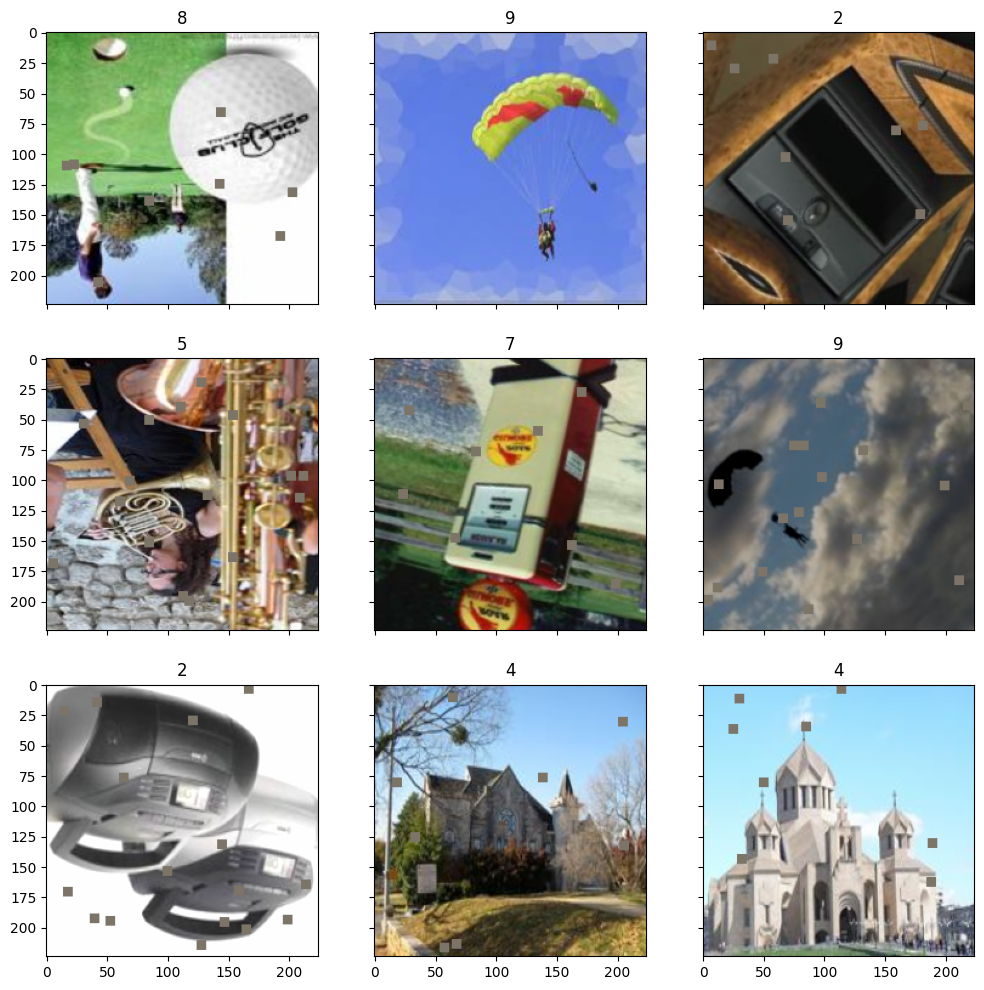

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_img = int(np.random.uniform(0,len(train_files)))
    im_val, label = train_dataset[random_img]
    img_label = label
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)

print('Train and Valid datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_loader), len(train_dataset)))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_loader), len(val_dataset)))

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train        1184      9469
Valid         491      3925


In [ ]:
# Функция обучения и инференса модели

def train_val_model(model, loss, optimizer, scheduler, num_epochs):

    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}

    best_acc = 0.

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, name=CFG.model_name, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="\n")
        for phase in ['train', 'val']:
            if phase == 'train': # Если фаза == train
                # ВАШ КОД ЗДЕСЬ # Берем train_dataset
                # ВАШ КОД ЗДЕСЬ # Делаем 1 шаг (произошла одна эпоха)
                # ВАШ КОД ЗДЕСЬ  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: # Если фаза == val
                # ВАШ КОД ЗДЕСЬ # Берем valid_dataset
                # ВАШ КОД ЗДЕСЬ   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)

            running_loss = 0.
            running_acc = 0.

            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = # ВАШ КОД ЗДЕСЬ # Тензор с изображениями переводим на GPU
                labels = # ВАШ КОД ЗДЕСЬ # Тензор с лейблами переводим на GPU

                # ВАШ КОД ЗДЕСЬ # Обнуляем градиент,чтобы он не накапливался

                with torch.set_grad_enabled(phase == 'train'): # Если фаза train, то активируем все градиенты (те, которые не заморожены)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) # Посчитали  Loss
                    preds_class = preds.argmax(dim=1) # Получаем класс, берем .argmax(dim=1) нейрон с максимальной активацией

                    if phase == 'train':
                        # ВАШ КОД ЗДЕСЬ # Считаем градиент
                        # ВАШ КОД ЗДЕСЬ # Считаем шаг градиентного спуска

                # Статистика
                running_loss += loss_value.item() # Считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  # Считаем accuracy

            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе
            epoch_acc = running_acc / len(dataloader) # Считаем Loss на кол-во бачей в эпохе

            if CFG.wandb and phase == 'train':
              wandb.log({'train_loss': epoch_loss,
                   'train_accuracy': epoch_acc})

            if CFG.wandb and phase == 'val':
              wandb.log({'test_loss': epoch_loss,
                   'test_accuracy': epoch_acc})

            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc), end="\n")

            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
              torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')

            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

    return model, loss_hist, acc_hist

In [ ]:
def train_val_model(model, loss, optimizer, scheduler, num_epochs):
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    best_acc = 0.

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, name=CFG.model_name, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                model.train()  # Установить модель в режим обучения
            else:
                dataloader = valid_loader
                model.eval()  # Установить модель в режим оценки

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)  # Переносим изображения на GPU
                labels = labels.to(device)  # Переносим лейблы на GPU

                optimizer.zero_grad()  # Обнуляем градиенты

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()  # Считаем градиенты
                        optimizer.step()  # Сделать шаг оптимизации

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if CFG.wandb and phase == 'train':
                wandb.log({'train_loss': epoch_loss, 'train_accuracy': epoch_acc})

            if CFG.wandb and phase == 'val':
                wandb.log({'val_loss': epoch_loss, 'val_accuracy': epoch_acc})

            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
                torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')

            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

    return model, loss_hist, acc_hist


## Подзадача №2.
Изучить внимательно, какие модели есть в библиотеке `timm` и выбрать несколько.

In [ ]:
# ====================================================
# My_Net - класс для создания модели
# ====================================================

class My_Net(torch.nn.Module):
    def __init__(self, model_name='resnet50', pretrained=False, effnet=False, value=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        # Замораживаем веса
        if value:
            for param in self.model.parameters():
                param.requires_grad = False

        # Добавляем полносвязанную классифицирующую голову
        if effnet:
            fc_inputs = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
            self.model.classifier = nn.Linear(fc_inputs, 10)  # Замените num_classes на нужное количество классов
        else:
            fc_inputs = self.model.fc.in_features
            self.model.fc = nn.Linear(fc_inputs, 10)  # Замените num_classes на нужное количество классов

    def forward(self, x):
        x = self.model(x)
        return x


In [ ]:
model = My_Net(CFG.model_name, pretrained=True, effnet=False, value=False) # Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этой модели на датасете ImageNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем Loss функцию
# В данном случае - это кросс-энтропия
loss = nn.CrossEntropyLoss()
# Метод градиентного спуска AdamW
optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Итак, поехали!

In [ ]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/30:


100%|██████████| 1184/1184 [02:29<00:00,  7.94it/s]


train loss: 0.89 accuracy: 0.78


100%|██████████| 491/491 [00:18<00:00, 26.79it/s]


val loss: 0.09 accuracy: 0.98
Epoch 1 - Save Best Accuracy: 0.98 Model

Epoch 2/30:


100%|██████████| 1184/1184 [02:24<00:00,  8.17it/s]


train loss: 0.36 accuracy: 0.89


100%|██████████| 491/491 [00:18<00:00, 26.69it/s]


val loss: 0.07 accuracy: 0.98
Epoch 3/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.06it/s]


train loss: 0.28 accuracy: 0.92


100%|██████████| 491/491 [00:18<00:00, 26.48it/s]


val loss: 0.12 accuracy: 0.98
Epoch 4/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.08it/s]


train loss: 0.23 accuracy: 0.93


100%|██████████| 491/491 [00:19<00:00, 25.75it/s]


val loss: 0.07 accuracy: 0.98
Epoch 4 - Save Best Accuracy: 0.98 Model

Epoch 5/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.20 accuracy: 0.94


100%|██████████| 491/491 [00:18<00:00, 26.13it/s]


val loss: 0.06 accuracy: 0.98
Epoch 6/30:


100%|██████████| 1184/1184 [02:25<00:00,  8.11it/s]


train loss: 0.16 accuracy: 0.95


100%|██████████| 491/491 [00:18<00:00, 26.33it/s]


val loss: 0.06 accuracy: 0.98
Epoch 7/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.15 accuracy: 0.95


100%|██████████| 491/491 [00:18<00:00, 26.77it/s]


val loss: 0.06 accuracy: 0.98
Epoch 7 - Save Best Accuracy: 0.98 Model

Epoch 8/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.08it/s]


train loss: 0.13 accuracy: 0.96


100%|██████████| 491/491 [00:18<00:00, 26.49it/s]


val loss: 0.06 accuracy: 0.98
Epoch 9/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.07it/s]


train loss: 0.12 accuracy: 0.96


100%|██████████| 491/491 [00:18<00:00, 26.64it/s]


val loss: 0.05 accuracy: 0.98
Epoch 9 - Save Best Accuracy: 0.98 Model

Epoch 10/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.07it/s]


train loss: 0.11 accuracy: 0.96


100%|██████████| 491/491 [00:18<00:00, 26.63it/s]


val loss: 0.06 accuracy: 0.98
Epoch 11/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.08it/s]


train loss: 0.09 accuracy: 0.97


100%|██████████| 491/491 [00:18<00:00, 26.59it/s]


val loss: 0.06 accuracy: 0.98
Epoch 12/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.09 accuracy: 0.97


100%|██████████| 491/491 [00:18<00:00, 26.22it/s]


val loss: 0.06 accuracy: 0.98
Epoch 13/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.11it/s]


train loss: 0.09 accuracy: 0.97


100%|██████████| 491/491 [00:18<00:00, 26.10it/s]


val loss: 0.09 accuracy: 0.98
Epoch 14/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.08 accuracy: 0.97


100%|██████████| 491/491 [00:18<00:00, 26.47it/s]


val loss: 0.07 accuracy: 0.98
Epoch 15/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.07 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.61it/s]


val loss: 0.07 accuracy: 0.98
Epoch 16/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.07 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.75it/s]


val loss: 0.07 accuracy: 0.98
Epoch 17/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.10it/s]


train loss: 0.06 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.78it/s]


val loss: 0.07 accuracy: 0.98
Epoch 18/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.10it/s]


train loss: 0.06 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.90it/s]


val loss: 0.08 accuracy: 0.98
Epoch 19/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.06 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.70it/s]


val loss: 0.09 accuracy: 0.97
Epoch 20/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.10it/s]


train loss: 0.06 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.38it/s]


val loss: 0.08 accuracy: 0.98
Epoch 21/30:


100%|██████████| 1184/1184 [02:25<00:00,  8.11it/s]


train loss: 0.05 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.18it/s]


val loss: 0.08 accuracy: 0.98
Epoch 22/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.11it/s]


train loss: 0.05 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.31it/s]


val loss: 0.07 accuracy: 0.98
Epoch 23/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.10it/s]


train loss: 0.05 accuracy: 0.98


100%|██████████| 491/491 [00:18<00:00, 26.70it/s]


val loss: 0.07 accuracy: 0.98
Epoch 24/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.11it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 491/491 [00:18<00:00, 26.89it/s]


val loss: 0.09 accuracy: 0.97
Epoch 25/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.08it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 491/491 [00:18<00:00, 26.68it/s]


val loss: 0.07 accuracy: 0.98
Epoch 26/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.07it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 491/491 [00:18<00:00, 26.76it/s]


val loss: 0.09 accuracy: 0.98
Epoch 27/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 491/491 [00:18<00:00, 26.77it/s]


val loss: 0.10 accuracy: 0.97
Epoch 28/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.10it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 491/491 [00:18<00:00, 26.31it/s]


val loss: 0.08 accuracy: 0.98
Epoch 29/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.10it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 491/491 [00:18<00:00, 26.16it/s]


val loss: 0.09 accuracy: 0.98
Epoch 30/30:


100%|██████████| 1184/1184 [02:26<00:00,  8.09it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 491/491 [00:18<00:00, 26.33it/s]

val loss: 0.07 accuracy: 0.98


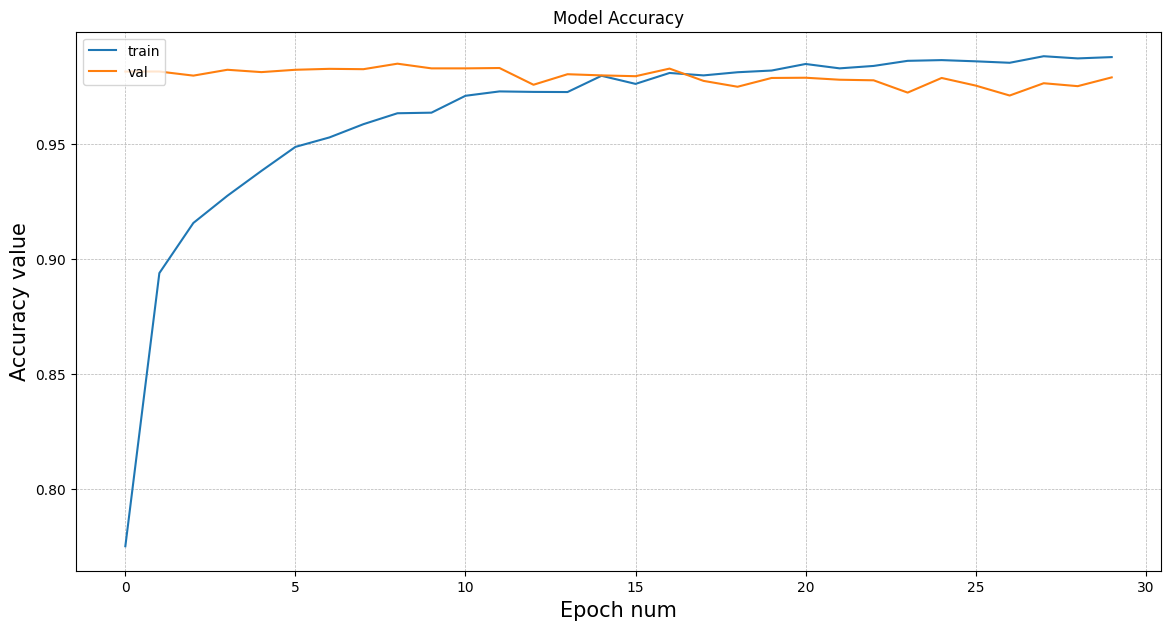

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')